In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%cd /Midgard/home/amirme/an_explanation_model
from source.project_manager import (
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from source.data_manager import plot_masks,fisher_information,preprocess_masks,symmetric_minmax_normalize,minmax_normalize,sum_channels
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "viridis"}

/Midgard/home/amirme/an_explanation_model


2023-09-21 13:32:47.202924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 13:32:53.901455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/Midgard/home/amirme/miniconda3/envs/xmodel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
project_metadata = load_experiment_metadata(glob_path="experiment_3.2/*")
print(project_metadata.columns)
project_metadata = project_metadata.set_index(
    [
        "stream_name",
        "stream_statistic",
        "image_index",
        "alpha_mask_value",
        "projection_top_k",
    ]
).sort_index()
print(project_metadata.shape)

Index(['method', 'alpha_mask_type', 'alpha_mask_value', 'projection_type',
       'projection_top_k', 'baseline_mask_type', 'normalize_sample',
       'write_demo', 'architecture', 'max_batches', 'min_change', 'seed',
       'batch_size', 'num_classes', 'input_shape', 'image_index',
       'monitored_statistic', 'monitored_stream', 'dataset', 'output_layer',
       'label', 'image_path', 'time_to_compute', 'batch_index',
       'monitored_statistic_change', 'data_path', 'stream_name',
       'stream_statistic', 'csv_file_path'],
      dtype='object')
(330, 24)


In [14]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))

stream_name            stream_statistic  image_index  alpha_mask_value  projection_top_k
log_probs              meanx             5            0.0               1                   1
vanilla_grad_mask      meanx2            5            0.1               8                   1
results_at_projection  meanx             5            0.6               4                   1
                                                                        5                   1
                                                                        6                   1
                                                                                           ..
                                                      0.0               4                   1
                                                                        5                   1
                                                                        6                   1
                                                                 

In [15]:
for name in project_metadata.index.names:
    print(
        name,
        "=",
        project_metadata.index.get_level_values(name).value_counts().to_dict(),
    )

stream_name = {'log_probs': 70, 'results_at_projection': 70, 'vanilla_grad_mask': 70}
stream_statistic = {'meanx': 140, 'meanx2': 70}
image_index = {5: 210}
alpha_mask_value = {0.0: 30, 0.1: 30, 0.2: 30, 0.3: 30, 0.4: 30, 0.5: 30, 0.6000000000000001: 30}
projection_top_k = {1: 21, 2: 21, 3: 21, 4: 21, 5: 21, 6: 21, 7: 21, 8: 21, 9: 21, 10: 21}


['alpha_mask_value', 'projection_top_k']


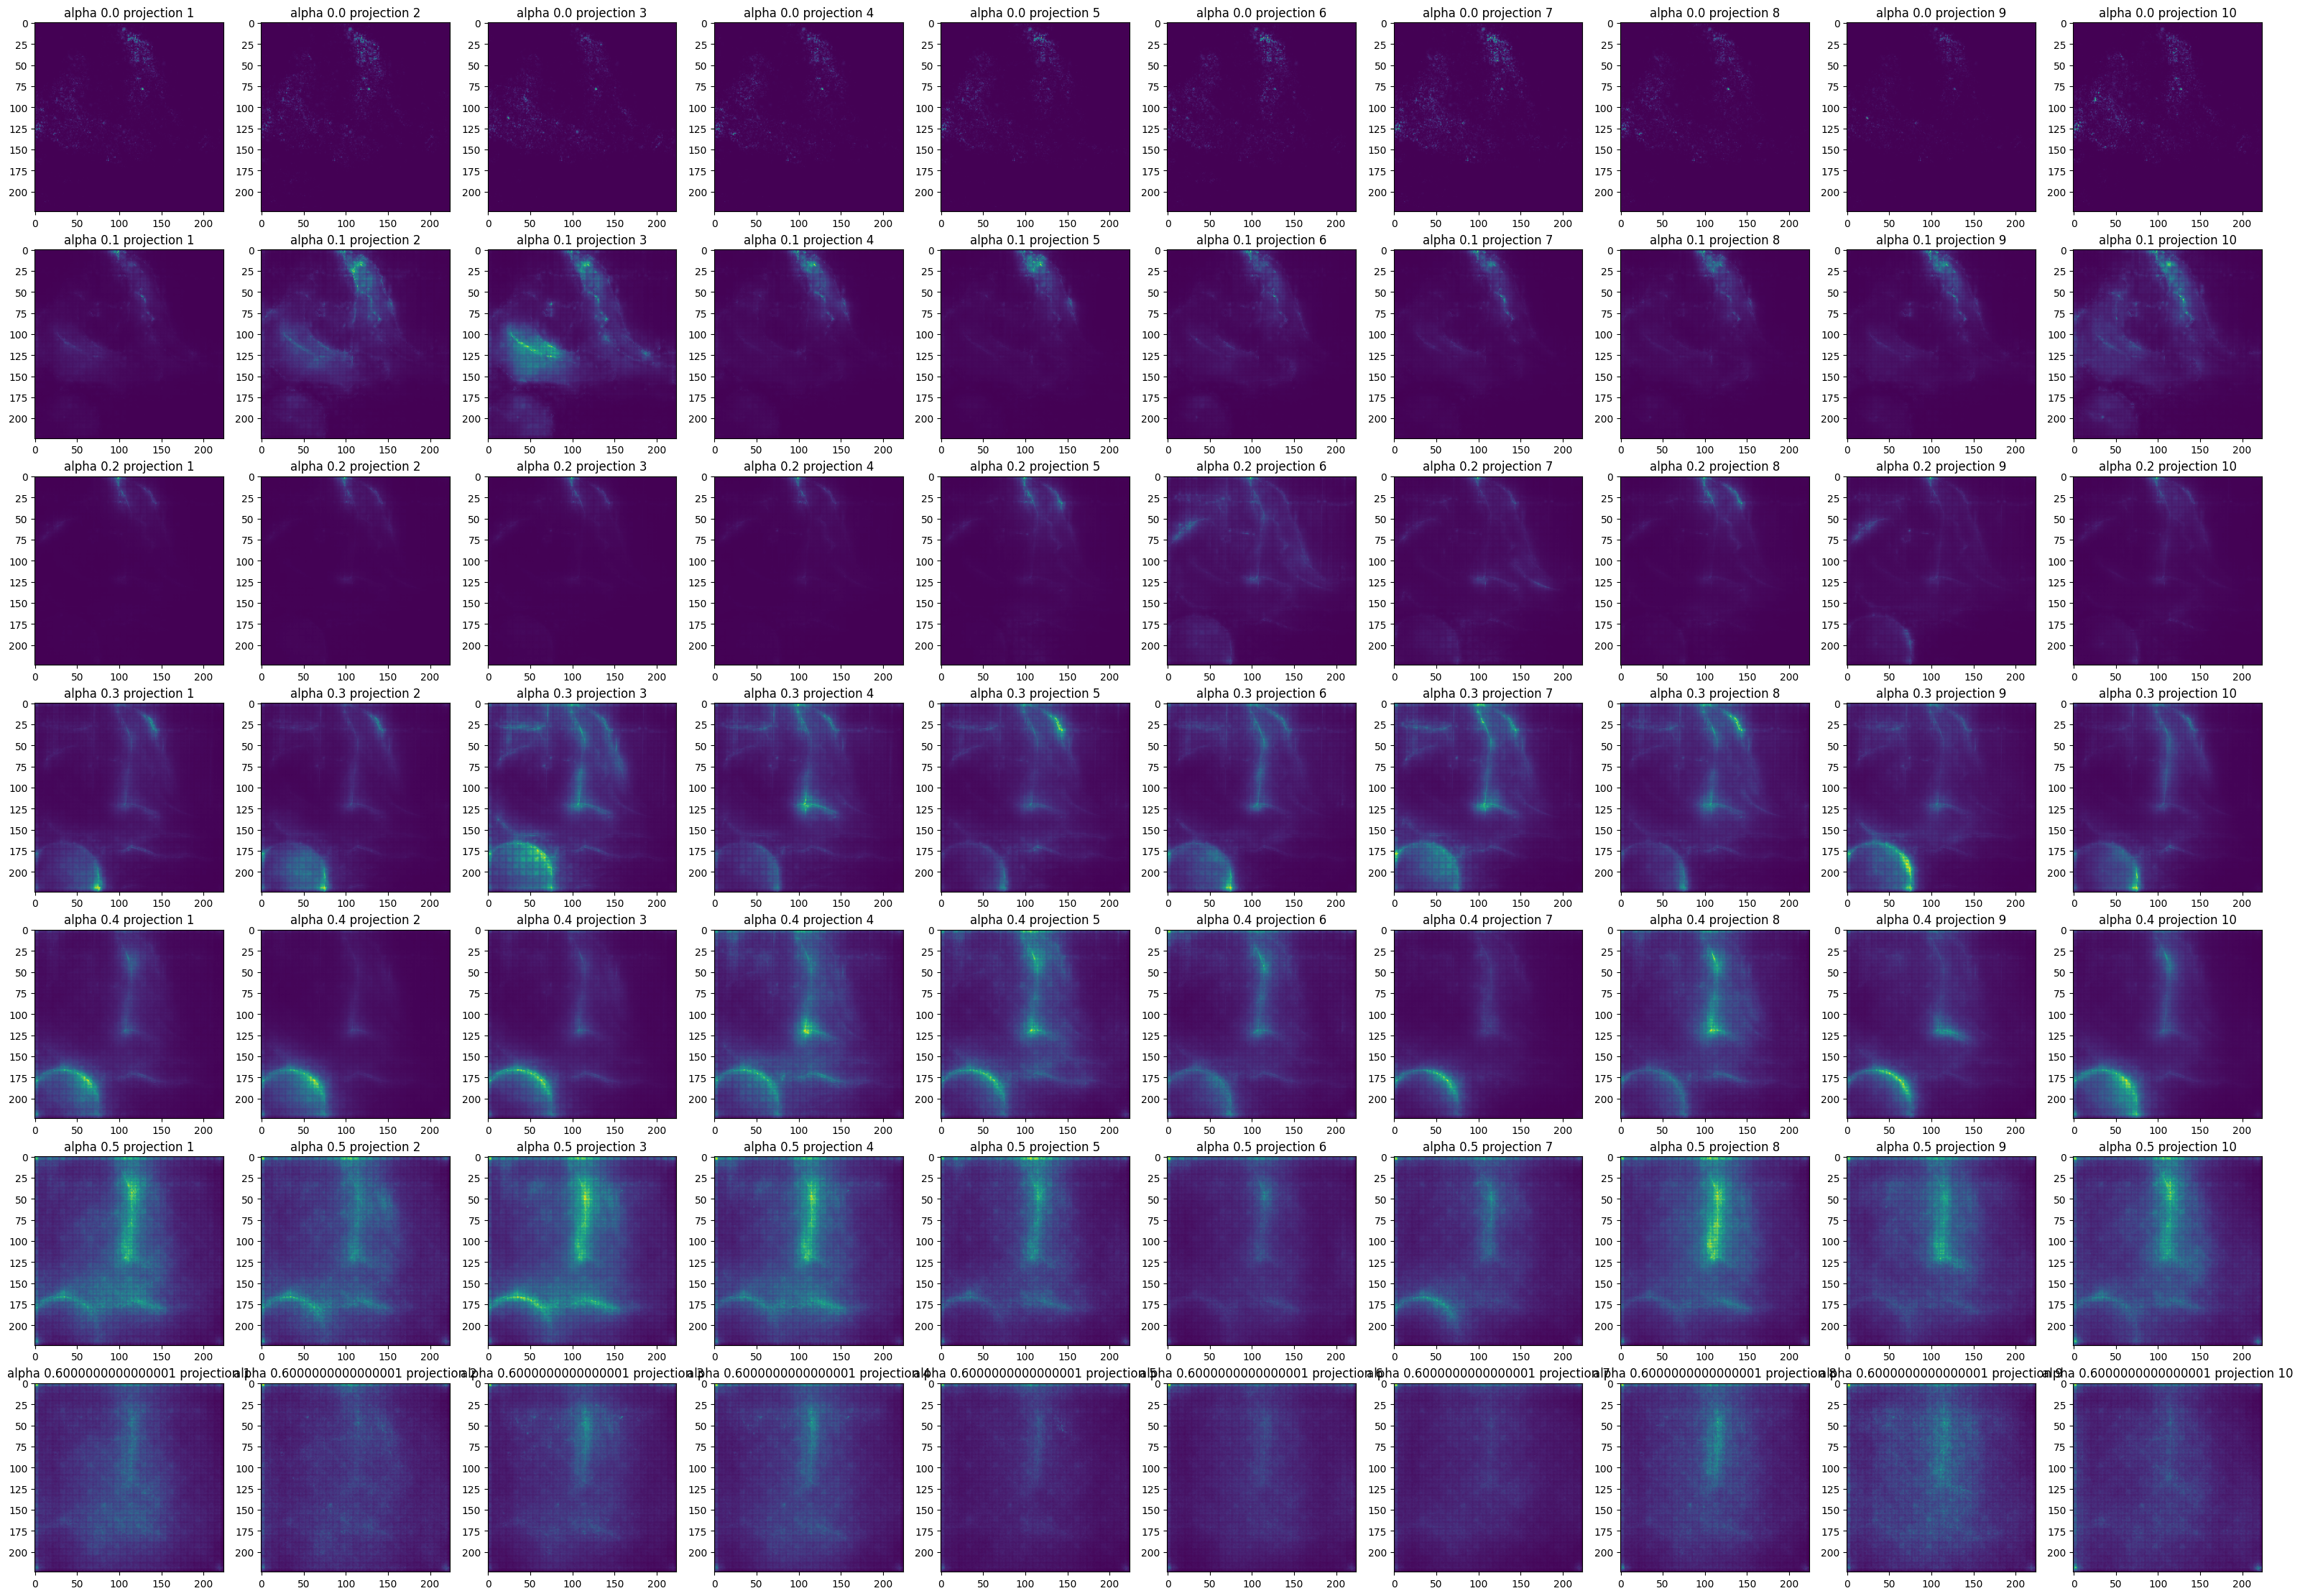

In [16]:
image_index = 5
meanx2 = project_metadata.loc[
    (
        "vanilla_grad_mask",
        "meanx2",
        image_index,
    ),
    "data_path",
].apply(lambda x: np.load(x))
meanx2 = preprocess_masks(meanx2, preprocesses=[sum_channels, minmax_normalize])
# meanx2 = meanx2.droplevel(0)
print(meanx2.index.names)

titles = meanx2.index.to_series().apply(lambda x: f"alpha {x[0]} projection {x[1]}")
plot_masks(meanx2, titles=titles, imshow_args=imshow_args, ncols=10)

Text(0.5, 1.0, 'image_index projection_top_k')

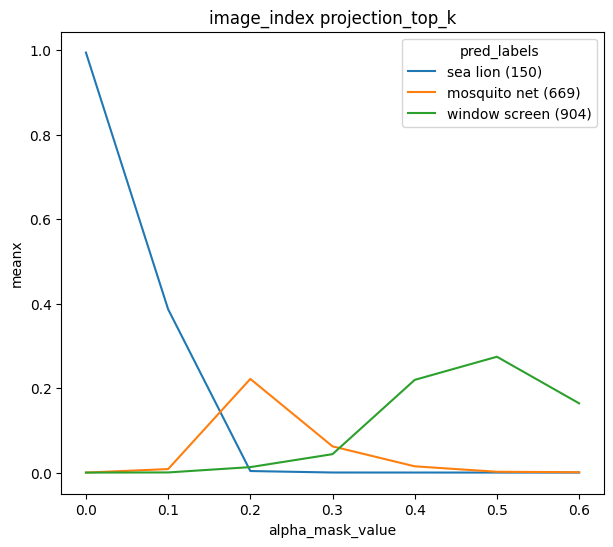

In [71]:
temp_metadata = project_metadata.loc[("log_probs", "meanx", 5, slice(None), 1), :]
temp_metadata = temp_metadata.droplevel(
    ["projection_top_k", "image_index", "stream_statistic", "stream_name"]
)
meanx = temp_metadata.loc[:, "data_path"].apply(lambda path: np.load(path))

meanx.name = "values"
get_top_k = 1
pred_ids = meanx.apply(lambda x: np.argpartition(x, -get_top_k)[-get_top_k:])
pred_ids.name = "pred_ids"
pred_ids = pred_ids.to_frame()
alphas = pred_ids.index.get_level_values("alpha_mask_value")
pred_ids = pred_ids.explode("pred_ids")
pred_ids = pd.DataFrame(pred_ids["pred_ids"].unique(), columns=["pred_ids"])
pred_ids = pd.concat(
    {alpha: pred_ids for alpha in alphas}, names=["alpha_mask_value"], axis=0
)
temp_df = pred_ids.apply(
    lambda x: meanx.loc[x.name[0],][x["pred_ids"]],
    axis=1,
)
temp_df.name = "meanx"
temp_df = np.exp(temp_df)
pred_ids["pred_labels"] = pred_ids["pred_ids"].apply(
    lambda x: IMAGENET_LABELS[x].split(",")[0] + f" ({x})"
)
pred_ids = pd.concat([pred_ids, temp_df], axis=1)

nrows= 1
fig,ax = plt.subplots(nrows,1,figsize=(7,6*nrows))
sns.lineplot(
    ax = ax,
    x="alpha_mask_value",
    y="meanx",
    hue="pred_labels",
    data=pred_ids,
    palette="tab10",
)
ax.set_title(f"image_index {name}")

['alpha_mask_value', 'projection_top_k']


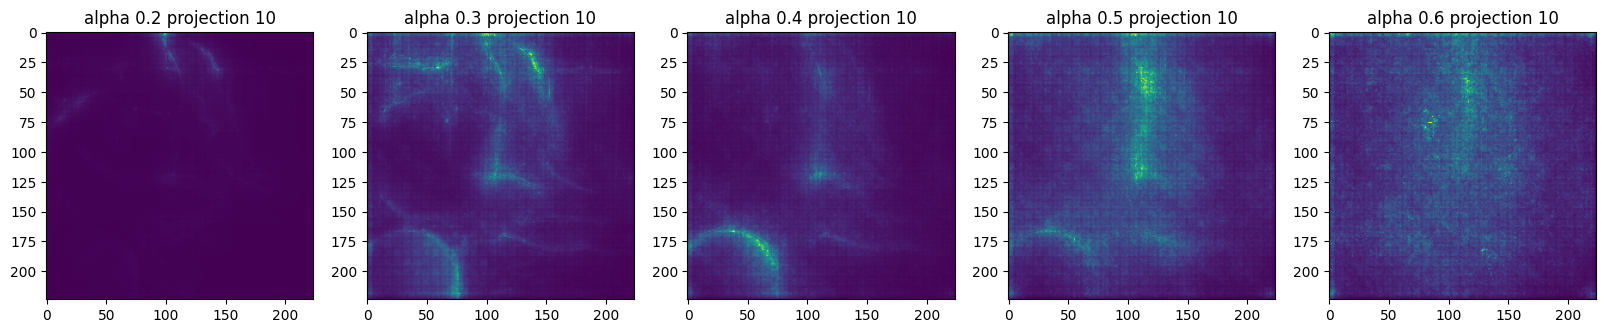